In [1]:
import jax.numpy as np
import jax
from jax.config import config
# config.update("jax_debug_nans", True)  # https://github.com/google/jax/issues/475#issuecomment-470417985
config.update('jax_platform_name', 'cpu')  # https://github.com/google/jax/issues/1598#issuecomment-718621972
# config.update('jax_disable_jit', True)

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import razor

In [2]:
def make_table_3d():
    return np.array([
        [-1, -1, 1, 1],
        [-1, +1, 1, 1],
        [+1, +1, 1, 1],
        [+1, -1, 1, 1],
        [-1, -1, 0, 1],
        [-1, +1, 0, 1],
        [+1, +1, 0, 1],
        [+1, -1, 0, 1]
    ])

def t_translate(xyz):
    return np.array([
        [1, 0, 0, xyz[0]],
        [0, 1, 0, xyz[1]],
        [0, 0, 1, xyz[2]],
        [0, 0, 0, 1]
    ])

def t_scale(xyz):
    return np.array([
        [xyz[0], 0, 0, 0],
        [0, xyz[1], 0, 0],
        [0, 0, xyz[2], 0],
        [0, 0, 0, 1]
    ])

def t_rotate_x(theta):
    return np.array([
        [1, 0, 0, 0],
        [0, np.cos(theta), -np.sin(theta), 0],
        [0, np.sin(theta), +np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

def t_rotate_y(theta):
    return np.array([
        [np.cos(theta), 0, -np.sin(theta), 0],
        [0, 1, 0, 0],
        [np.sin(theta), 0, +np.sin(theta), 0],
        [0, 0, 0, 1]
    ])

def t_rotate_z(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0, 0],
        [np.sin(theta), +np.cos(theta), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def normalize(v):
    return v / np.linalg.norm(v)

def t_lookat(cam, pts, up):
    up = up[:3]
    z = normalize(pts - cam)[:3]
    x = normalize(np.cross(normalize(up), z))
    y = np.cross(z, x)
    
    c2w = np.array([
        [x[0], y[0], z[0], cam[0]],
        [x[1], y[1], z[1], cam[1]],
        [x[2], y[2], z[2], cam[2]],
        [0, 0, 0, 1]
    ])
    w2c = np.linalg.inv(c2w)
    return w2c

def perspective(pts, fov, n, f):
    z = pts[:, 2]
    x = pts[:, 0] / z
    y = pts[:, 1] / z
    z = f * (z - n) / (z * (f - n))
    w = np.ones_like(z)
    xyz = np.stack([x, y, z, w], axis=1)

    it = 1 / np.tan(fov / 2)
    s = t_scale(np.array([it, it, 1]))
    scaled = t_apply(xyz, s)
    squash = scaled.at[:, 2].set(0.)
    return squash

def t_apply(v, *ts):
    v = np.transpose(v)
    for t in ts:
        v = np.matmul(t, v)
    return np.transpose(v)

In [3]:
def render_table_3d(t, color='k', legs=True, frame=True):
    plt.axis('equal')
    plt.axis('off')
    plt.plot(t[0:4, 0], t[0:4, 1], f'{color}-', linewidth=4.)
    plt.plot(t[(3, 0), 0], t[(3, 0), 1], f'{color}-', linewidth=4.)
    if legs:
        for i in range(4):
            plt.plot(t[(i, i + 4), 0], t[(i, i + 4), 1], f'{color}-', linewidth=4.)
    if frame:
        plt.plot([-1, -1, 1, 1, -1], [-1, 1, 1, -1, -1], 'y--', linewidth=1.)

In [4]:
@jax.jit
def table_from_params(scale, wiggle, translate, campos, fov):
    table = make_table_3d() * 1.0
    table = table.at[:, :2].add(wiggle)
    table = t_apply(
        table,
        t_scale(scale),
        t_translate(np.concatenate([translate, np.zeros((1,))])),
        t_lookat(
            np.concatenate([campos, np.ones((1,))]),
            np.array([0, 0, 0, 1.]),
            np.array([0, 0, 1, 0.])
        )
    )
    table = perspective(table, fov * np.pi / 180, 0., 1.)
    return table[:, (0, 1)]

In [5]:
dummy = np.zeros(shape=(8, 2))

class table(razor.Model):
    def forward(self, t, obss):
        r = t.uniform_sample(()) * 8. + 8.
        theta = t.uniform_sample(()) * np.pi * 2  # previously / 2
        h = t.gaussian_sample(()) * 3.
        fov = t.gaussian_sample(()) * 5 + 45.
        campos = np.array([
            np.cos(theta) * r,
            np.sin(theta) * r,
            h
        ])

        gens = []
        ss = []
        for obs in obss:
            s = t.uniform_sample((3,)) * np.array([3.5, 3.5, 3.5]) + np.array([0.5, 0.5, 0.5])
            gen = table_from_params(
                scale=s,
                wiggle=t.gaussian_sample((8, 2)) * 0.01,
                translate=t.gaussian_sample((2,)) * 2.,
                campos=campos,
                fov=fov
            )
            t.gaussian_observe(gen, 0.01, obs)
            gens.append(gen)
            ss.append(s)
        return gens, ss
m = table([dummy, dummy])

  0%|          | 0/36 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Unconditional samples')

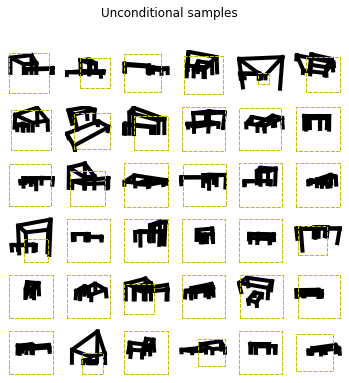

In [6]:
plt.figure(figsize=(6, 6))
for i in tqdm(range(36)):
    plt.subplot(6, 6, i + 1)
    render_table_3d(
        m.unpack(
            jax.random.normal(key=jax.random.PRNGKey(i), shape=(m.N,)),
            [dummy, dummy]
        )[0][0],
        color='k'
    )
    render_table_3d(
        m.unpack(
            jax.random.normal(key=jax.random.PRNGKey(i), shape=(m.N,)),
            [dummy, dummy]
        )[0][1],
        color='k'
    )
plt.suptitle('Unconditional samples')

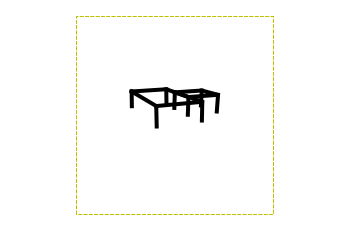

In [7]:
key = jax.random.PRNGKey(0)

key, subkey = jax.random.split(key)
obs, obs_s = m.unpack(
    jax.random.normal(key=subkey, shape=(m.N,)),
    [dummy, dummy]
)
render_table_3d(obs[0], 'k')
render_table_3d(obs[1], 'k')

key, subkey = jax.random.split(key)
q0 = jax.random.normal(key=subkey, shape=(m.N,))

key, subkey = jax.random.split(key)
samples = razor.hmc_sample(m, q0, subkey, 100, 20, 0, 1e-3, obs)

Text(0.5, 0.98, 'Inference trajectory samples')

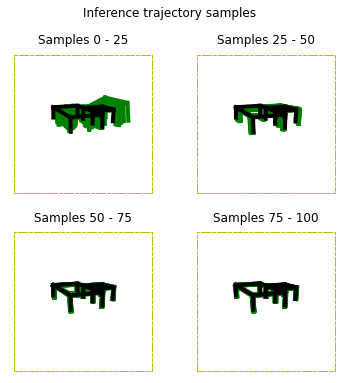

In [8]:
plt.figure(figsize=(6, 6))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    for j in range(25):
        render_table_3d(
            m.unpack(samples[i * 25 + j], [dummy, dummy])[0][0],
            color='g'
        )
        render_table_3d(
            m.unpack(samples[i * 25 + j], [dummy, dummy])[0][1],
            color='g'
        )
    render_table_3d(
        obs[0], color='k'
    )
    render_table_3d(
        obs[1], color='k'
    )
    plt.title(f'Samples {i * 25} - {(i + 1) * 25}')
plt.suptitle('Inference trajectory samples')

In [9]:
def diag(s):
    return np.sqrt(s[0] ** 2 + s[1] ** 2)

def loss(key, obs_p, q0, q0_):
    obss, ss = m.unpack(obs_p, [dummy, dummy])
    key, subkey = jax.random.split(key)
    samples = razor.hmc_sample(m, q0, subkey, 100, 20, 0, 1e-3, obss)
    inf, inf_s = m.unpack(samples[:].mean(axis=0), obss)


    obss_, ss_ = m.unpack(obs_p.at[2].add(+4.), [dummy, dummy])
    key, subkey = jax.random.split(key)
    samples_ = razor.hmc_sample(m, q0_, subkey, 100, 20, 0, 1e-3, obss_)
    inf_, inf_s_ = m.unpack(samples_[:].mean(axis=0), obss_)

    l = 0.
    l = l - (diag(samples_[:, (44, 45)].mean(axis=0)) - diag(samples[:, (44, 45)].mean(axis=0)))

    return l, (obss, samples, samples_)
dloss = jax.value_and_grad(loss, argnums=(1,), has_aux=True)


for seed in [12]:#tqdm(range(100)):
    key = jax.random.PRNGKey(seed)

    key, subkey = jax.random.split(key)
    obs_p = jax.random.normal(subkey, shape=(m.N,))

    q0 = obs_p
    q0_ = obs_p.at[2].add(+4.)

    import optax
    opt = optax.adam(learning_rate=0.05)
    opts = opt.init(obs_p)

    for i in tqdm(range(80 + 1), leave=False):
        key, subkey = jax.random.split(key)
        (l, (obss, samples, samples_)), (dl,) = dloss(subkey, obs_p, q0, q0_)
        q0 = samples[-1]
        q0_ = samples_[-1]

        if i > 10:
    #         obs_p = obs_p - dl * 1e0
            optu, opts = opt.update(dl, opts)
            obs_p = optax.apply_updates(obs_p, optu)

        if i % 10 == 0:
#             print(i, l, np.abs(dl).max())
            plt.figure(figsize=(6, 3))
            plt.subplot(1, 3, 1)
            render_table_3d(obss[0], color='r')
            render_table_3d(obss[1], color='b')
            render_table_3d(m.unpack(samples[-1], obss)[0][0], color='y-')
            render_table_3d(m.unpack(samples[-1], obss)[0][1], color='y-')
            plt.subplot(1, 3, 2)
            render_table_3d(m.unpack(obs_p.at[2].add(+4.), obss)[0][0], color='r')
            render_table_3d(m.unpack(obs_p.at[2].add(+4.), obss)[0][1], color='b')
            render_table_3d(m.unpack(samples_[-1], obss)[0][0], color='y-')
            render_table_3d(m.unpack(samples_[-1], obss)[0][1], color='y-')
            plt.subplot(1, 3, 3)
            render_table_3d(m.unpack(samples[-1].at[2].add(+4.), obss)[0][0], color='r')
            render_table_3d(m.unpack(samples[-1].at[2].add(+4.), obss)[0][1], color='b')
            plt.suptitle(f'Seed {seed}, after {i} steps, loss {l}')
            plt.savefig(f'out/size-constancy/{seed:02}-{i:03}.jpg')
            plt.close()
            
            
    for j, h in enumerate(tqdm(np.linspace(0, +4, 30), leave=False)):
        plt.figure()
        render_table_3d(m.unpack(obs_p.at[2].add(h), obss)[0][0], color='k', frame=False)
        render_table_3d(m.unpack(obs_p.at[2].add(h), obss)[0][1], color='k', frame=False)
        plt.savefig(f'out/size-constancy/vid/{seed:02}-A-{j:02}.jpg')
        plt.close()

        plt.figure()
        render_table_3d(m.unpack(samples[-1].at[2].add(h), obss)[0][0], color='k', frame=False)
        render_table_3d(m.unpack(samples[-1].at[2].add(h), obss)[0][1], color='k', frame=False)
        plt.savefig(f'out/size-constancy/vid/{seed:02}-B-{j:02}.jpg')
        plt.close()
        
        import os
        os.system(f'convert out/size-constancy/vid/{seed:02}-A-*.jpg out/size-constancy/vid/{seed:02}-A.gif');
        os.system(f'convert out/size-constancy/vid/{seed:02}-B-*.jpg out/size-constancy/vid/{seed:02}-B.gif');

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]